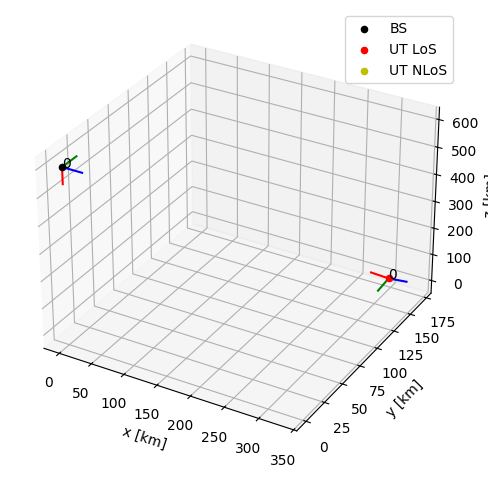

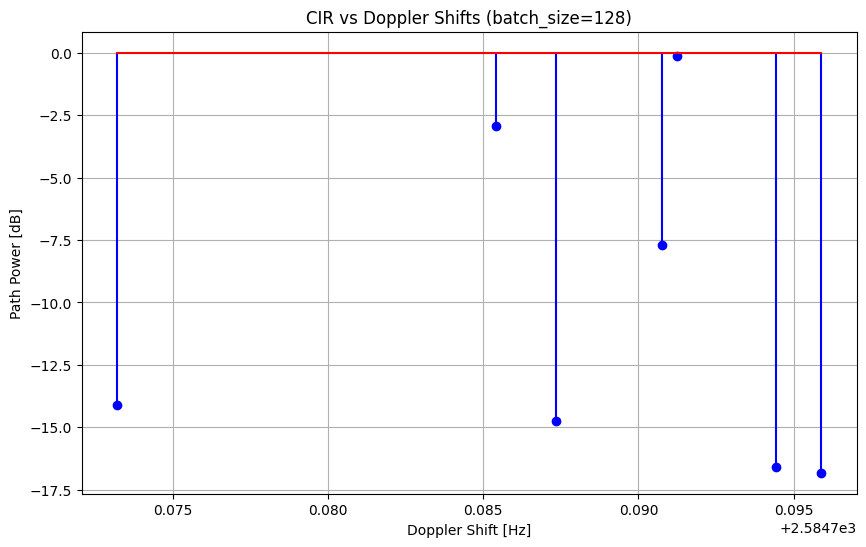

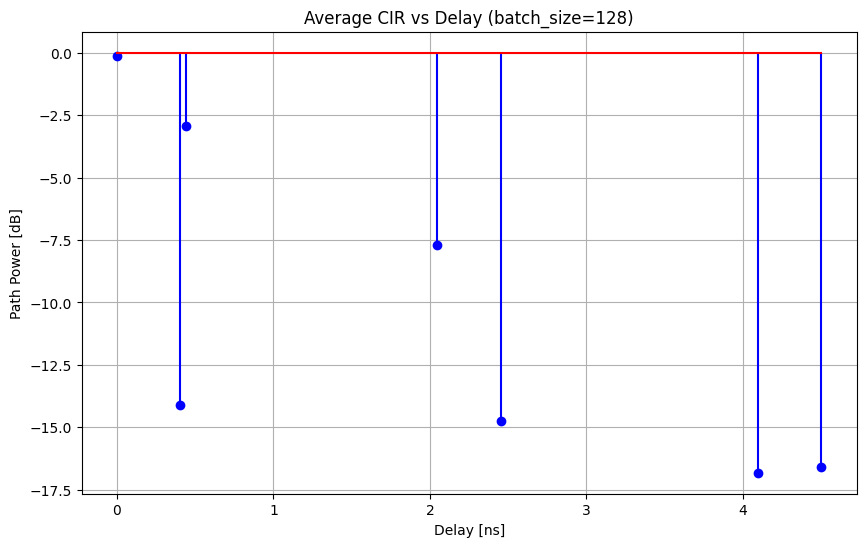

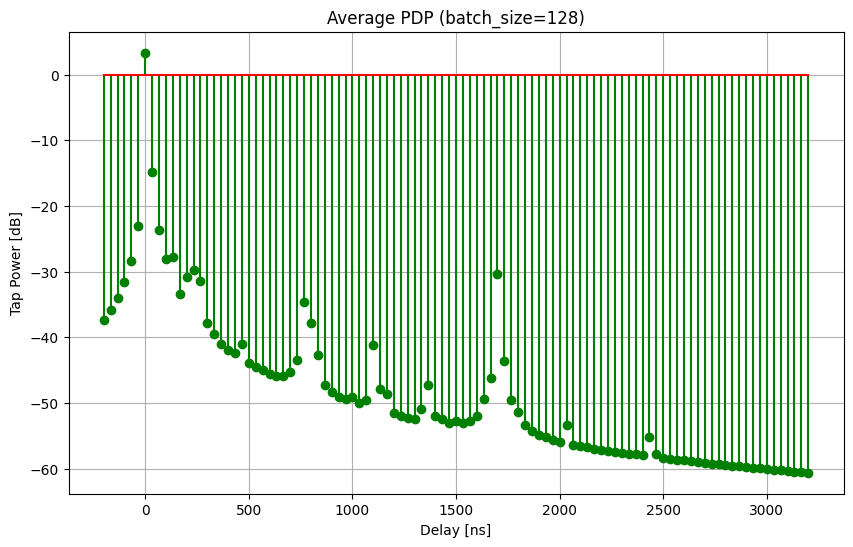

Channel coefficient shape is: (128, 1, 1, 1, 32, 7, 14)
Path delays shape is: (128, 1, 1, 7)
Discrete taps shape: (128, 1, 1, 1, 32, 14, 103)
Doppler shifts shape: (7,)


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sionna.phy.channel.tr38811 import AntennaArray, DenseUrban, Urban, SubUrban, Rural
from sionna.phy.channel import cir_to_time_channel, time_lag_discrete_time_channel
from sionna.phy.channel.tr38811.utils import gen_single_sector_topology as gen_ntn_topology

# Set random seed for reproducibility
#tf.random.set_seed(42)

# Step 1: Define antenna arrays for BS and UT
bs_array = AntennaArray(
    num_rows=4,
    num_cols=4,
    polarization='dual',
    polarization_type='cross',
    antenna_pattern='38.901',
    carrier_frequency=3.5e9  # 3.5 GHz
)

ut_array = AntennaArray(
    num_rows=1,
    num_cols=1,
    polarization='single',
    polarization_type='V',
    antenna_pattern='omni',
    carrier_frequency=3.5e9
)

# Step 2: Instantiate channel model
channel_model = DenseUrban(
    carrier_frequency=3.5e9,
    ut_array=ut_array,
    bs_array=bs_array,
    direction='downlink',
    elevation_angle=60.0,
    doppler_enabled = True,
    enable_pathloss=False,
    enable_shadow_fading=True
)

# Step 3: Set up network topology for batch_size=128
batch_size = 128
num_ut = 1
num_bs = 1

# Creates a new channel realization
topology = gen_ntn_topology(batch_size=batch_size, num_ut=num_ut, scenario="dur", bs_height=600000.0, elevation_angle=60.0)
channel_model.set_topology(*topology)
channel_model.show_topology()

# time stpes and sampling frequency
num_time_steps = 14
sampling_freq = 60e6

# Step 4: Generate CIR
a, tau = channel_model(num_time_steps, sampling_freq)  # num_time_steps=28, sampling_frequency=40 MHz

# Step 5: Compute Doppler shifts
# Shape of a: [128, 1, 1, 1, 32, num_paths, 28]
# Use phase difference between consecutive time steps to estimate Doppler
# Take first batch, first rx/tx, average over tx_ant
a_subset = a[0, 0, 0, 0, :, :, :]  # Shape: [32, num_paths, 28]
phase = np.angle(a_subset)  # Shape: [32, num_paths, 28]
delta_phase = np.diff(phase, axis=2)  # Phase difference: [32, num_paths, 27]
delta_t = 1 / sampling_freq  # Time step = 25 ns
doppler_shifts = np.mean(delta_phase / (2 * np.pi * delta_t), axis=(0, 2))  # Shape: [num_paths]

# Step 6: Plot CIR vs Doppler shifts
# Average |a|^2 over batch_size (128), tx_ant (32), time_steps (28)
power_cir = np.mean(np.abs(a[:, 0, 0, 0, :, :, :])**2, axis=(0, 1, 3))  # Shape: [num_paths]
power_cir_db = 10 * np.log10(power_cir + 1e-12)  # dB scale

plt.figure(figsize=(10, 6))
plt.stem(doppler_shifts, power_cir_db, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.xlabel('Doppler Shift [Hz]')
plt.ylabel('Path Power [dB]')
plt.title('CIR vs Doppler Shifts (batch_size=128)')
plt.grid(True)
plt.show()

# Step 7: Plot CIR vs Delay (for reference)
delays_cir = tau[0, 0, 0, :]  # Shape: [num_paths], first batch
plt.figure(figsize=(10, 6))
plt.stem(delays_cir * 1e9, power_cir_db, linefmt='b-', markerfmt='bo', basefmt='r-')
plt.xlabel('Delay [ns]')
plt.ylabel('Path Power [dB]')
plt.title('Average CIR vs Delay (batch_size=128)')
plt.grid(True)
plt.show()

# Step 8: Plot PDP (for completeness)
bandwidth = 30e6
maximum_delay_spread = 3e-6
l_min, l_max = time_lag_discrete_time_channel(bandwidth, maximum_delay_spread=maximum_delay_spread)
hm = cir_to_time_channel(bandwidth, a, tau, l_min, l_max, normalize=False)
power_pdp = np.mean(np.abs(hm[:, 0, :, 0, :, :, :])**2, axis=(0, 1, 2, 3))  # Shape: [num_taps]
power_pdp_db = 10 * np.log10(power_pdp + 1e-12)
delays_pdp = np.arange(l_min, l_max + 1) / bandwidth

plt.figure(figsize=(10, 6))
plt.stem(delays_pdp * 1e9, power_pdp_db, linefmt='g-', markerfmt='go', basefmt='r-')
plt.xlabel('Delay [ns]')
plt.ylabel('Tap Power [dB]')
plt.title('Average PDP (batch_size=128)')
plt.grid(True)
plt.show()

# Debug shapes
print("Channel coefficient shape is:", a.shape)
print("Path delays shape is:", tau.shape)
print("Discrete taps shape:", hm.shape)
print("Doppler shifts shape:", doppler_shifts.shape)